## A Lagrangian analysis workflow using the open source Python library clouddrift

### A demonstration for the [Building Upon the EarthCube Community workshop](https://isi-usc-edu.github.io/building-upon-the-earthcube-community/)

#### Shane Elipot, Milan Curcic, Philippe Miron

In [1]:
Author1 = {"name": "Elipot, Shane", "affiliation": "University of Miami", "email": "selipot@miami.edu", "orcid": "0000-0001-6051-5426 "}
Author2 = {"name": "Curcic, Milan", "affiliation": "University of Miami", "email": "mcurcic@miami.edu", "orcid": "0000-0002-8822-7749"}
Author3 = {"name": "Miron, Philippe", "affiliation": "Florida State University", "email": "pmiron@fsu.edu", "orcid": "0000-0002-8520-6221"}

## Purpose

For data, *Lagrangian* refers to oceanic and atmosphere information acquired by observing platforms drifting with the flow they are embedded within, but also refers more broadly to the data originating from uncrewed platforms, vehicles, and animals that gather data along their unrestricted and often complex paths. Because such paths traverse both spatial and temporal dimensions, Lagrangian data often convolve spatial and temporal information that cannot always readily be organized in common data structures and stored in standard file formats with the help of common libraries and standards. As such, for both originators and users, Lagrangian data present challenges that the [EarthCube CloudDrift](https://github.com/Cloud-Drift) project aims to overcome.

The *clouddrift* library version 0.X.0 consists of four modules: `raggedarray`,`analyses`,`datasets`,`haversine`,`sphere`

This notebook consists of ...

Since the *CloudDrift* project aims at accelerating the use of Lagrangian data for atmospheric, oceanic, and climate sciences, we hope that the users of this notebook will provide us with feedback on its ease of use and the intuitiveness of the proposed methods in order to guide the on-going development of the *clouddrift* *Python* package.

## Technical contributions

- ?

## Methodology


## Results

## Funding

In [2]:
Award1 = {"agency": "NSF EarthCube", "award_code": "2126413", "award_URL": "https://www.nsf.gov/awardsearch/showAward?AWD_ID=2126413"}
Award2 = {"agency": "Atlantic Oceanographic and Meteorological Laboratory", "award_code": "", "award_URL": "https://www.aoml.noaa.gov/global-drifter-program"}
Award3 = {"agency": "NOAA’s Global Ocean Monitoring and Observing Program", "award_code": "", "award_URL": "https://globalocean.noaa.gov"}

## Keywords

In [3]:
keywords=["lagrangian", "drifters", "data structures"]

## Contents

1. Example of segment to calculate velocity
2. Example of chunks to calculate the Latitude-Frequency spectra for constant-length time series

## Library Import

In [4]:
# core packages
import clouddrift as cd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime

# plotting packages
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [5]:
from clouddrift.analysis import segment, chunk, apply_ragged, velocity_from_position, prune, subset 

# Lagrangian dataset

The NOAA GDP dataset is directly available from the clouddrift library thanks to a function of the `datasets` *clouddrift* module.
The data is accessed from a public AWS S3 bucket accessible at https://registry.opendata.aws/noaa-oar-hourly-gdp/ with the `gdp1h()` function which lazily opens a zarr store as an xarray Dataset.

In [6]:
# ds = cd.datasets.gdp1h()
# alternatively, one can open the dataset as follows
# url_path = 'https://noaa-oar-hourly-gdp-pds.s3.us-east-1.amazonaws.com/latest/'
# file = url_path+'gdp_v2.00.nc'+'#mode=bytes'
# ds = xr.open_dataset(file,engine='netcdf4',decode_times=True)
# or use a local copy
file = '/Users/selipot/Data/awss3/latest/gdp_v2.00.zarr'
#file = '/Users/selipot/Data/awss3/latest/'+'gdp_v2.00.nc'+'#mode=bytes'
ds = xr.open_dataset(file,engine='zarr',decode_times=True)

# 1. Exploring the GDP hourly dataset
## 1.1 First look, one trajectory

In [7]:
ds

<xarray.Dataset>
Dimensions:                (traj: 17324, obs: 165754333)
Coordinates:
    ids                    (obs) int64 ...
    lat                    (obs) float32 ...
    lon                    (obs) float32 ...
    time                   (obs) datetime64[ns] ...
Dimensions without coordinates: traj, obs
Data variables: (12/55)
    BuoyTypeManufacturer   (traj) |S20 ...
    BuoyTypeSensorArray    (traj) |S20 ...
    CurrentProgram         (traj) float64 ...
    DeployingCountry       (traj) |S20 ...
    DeployingShip          (traj) |S20 ...
    DeploymentComments     (traj) |S20 ...
    ...                     ...
    sst1                   (obs) float64 ...
    sst2                   (obs) float64 ...
    typebuoy               (traj) |S10 ...
    typedeath              (traj) int8 ...
    ve                     (obs) float32 ...
    vn                     (obs) float32 ...
Attributes: (12/16)
    Conventions:       CF-1.6
    acknowledgement:   Elipot, Shane; Sykulski, Adam; Lumpkin, Rick; Centurio...
    contributor_name:  NOAA Global Drifter Program
    contributor_role:  Data Acquisition Center
    date_created:      2022-12-09T06:02:29.684949
    doi:               10.25921/x46c-3620
    ...                ...
    processing_level:  Level 2 QC by GDP drifter DAC
    publisher_email:   aoml.dftr@noaa.gov
    publisher_name:    GDP Drifter DAC
    publisher_url:     https://www.aoml.noaa.gov/phod/gdp
    summary:           Global Drifter Program hourly data
    title:             Global Drifter Program hourly drifting buoy collection

The metadata for each individual drifter (e.g. `BuoyTypeSensor`) are stored in variables with length `traj`, but the Lagrangian variables of this dataset (that is the data along trajectories such as latitude, longitude, velocity components, sea surface temperature etc.) are stored as *ragged arrays* with dimension `obs`:

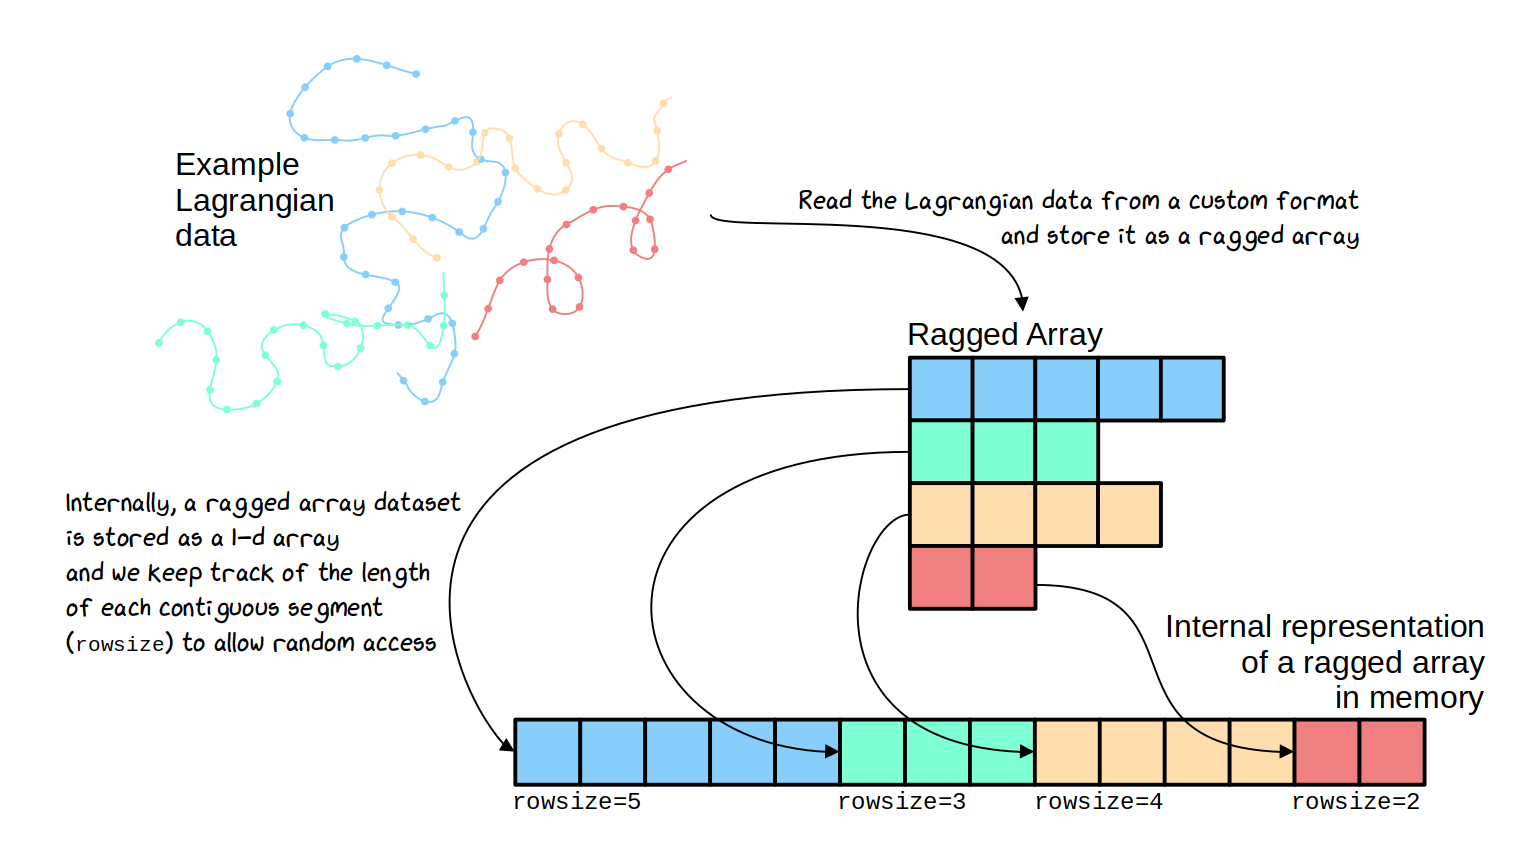

- The principle of this data structure is depicted in the diagram above. If the Lagrangian trajectories were all of equal length, the data would form regular two-dimensional arrays. But since the length of the trajectories differ, they conceptually form an array with "ragged" ends. We can conceptually keep this ragged array structure when dealing with the data but internally the data are stored as a 1-d array. 

- In order to access the data for one given trajectory, one needs to build a trajectory index, otherwise the data concatenated as a 1-d vector is just that. Fortunatelly for us, the dataset comes with an identification number variable, or ID, which can be used to build such an index. For this, we use the `segment` function from the *clouddrift* library which divides an array based on differences of consecutive values. Since in the GDP dataset the `ds.ids` variable repeats the ID number for all observations of a single drifter, it can be used to find the separation, or end of "rows" between the trajectories in the data.   
 
- However, please note that the GDP dataset distributed as ragged array *already* comes with a pre-calculated `rowsize` variable that indicates the length of each row. And the size of `rowsize` (17324 here) indicates the actual number of rows.

In [8]:
# Because the drifter ids are not monotonically increasing, we need to run the `segment` function twice for positive and negative integer differences of IDs. 
# If we knew they were monoyonically increasing, we could simply do rowsize_test = segment(ds.ids,0)
rowsize_test = segment(ds.ids,0.5,rowsize=segment(ds.ids,-0.5))
# verify that the calculated row size is equal to the ds.rowsize variable from the dataset
display('Length of calculated row sizes: '+str(np.shape(rowsize_test)))
display('Are all the calculated row sizes equal to the sizes provided by the dataset? '+str(np.all(rowsize_test==ds.rowsize.to_numpy())))
display('Total number of Lagrangian data points in the dataset: '+ str(np.sum(rowsize_test)))

'Length of calculated row sizes: (17324,)'

'Are all the calculated row sizes equal to the sizes provided by the dataset? True'

'Total number of Lagrangian data points in the dataset: 165754333'

The NOAA GDP hourly dataset therefore contains 17324 individual trajectories totalling 165,754,333 data points. In order to be able to access the data of each individual drifter, we must use the `rowsize` variable to get the indices for the beginnings and ends of each row:

In [9]:
# Computing a cumulative sum of rowsize starting from 0 creates the needed trajectory index
traj_index = np.insert(np.cumsum(ds.rowsize.values), 0, 0)

Now we can operate on a single row of the ragged array thanks to the index, that is work with the data from a single drifter. As an example:

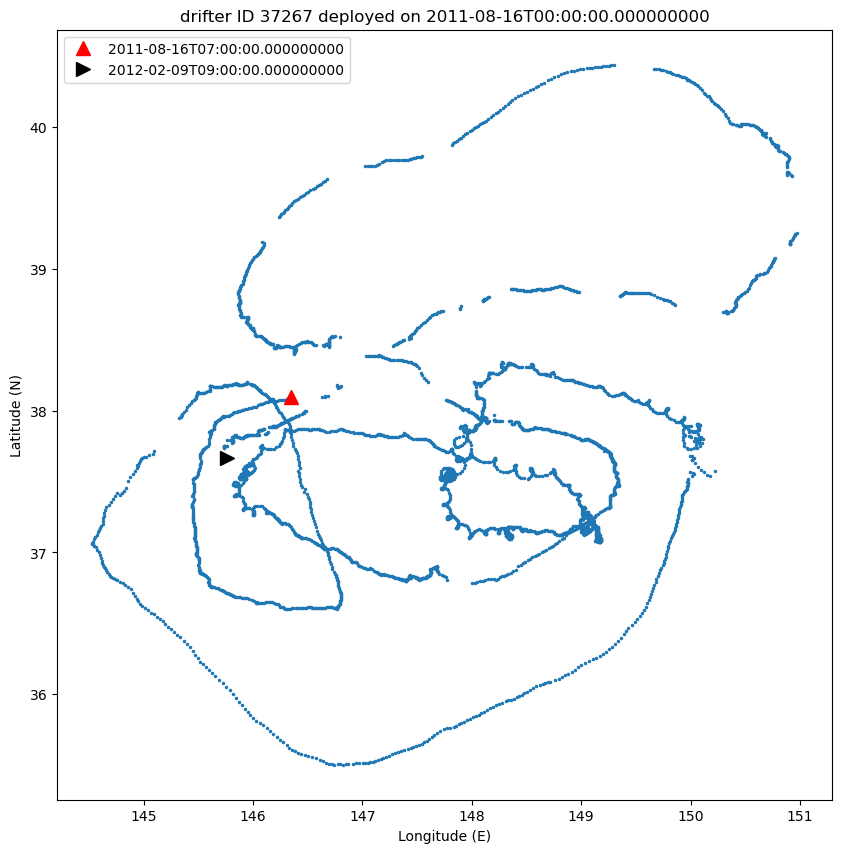

In [10]:
# here for example we examine row number 10002 (drifter ID 37267) of the ragged arrays and display latitude vs longitude
j = 1002 #1002 is a good one
row = slice(traj_index[j], traj_index[j+1]) # create a data slice for that row

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10, 10))
ax.plot(ds.lon[row],ds.lat[row],marker='.',markersize=3,linestyle='none')
ax.plot(ds.lon[row][0],ds.lat[row][0],marker='^',markersize=10,color='r',label=str(ds.time[row][0].values),linestyle='none') # plot first point
ax.plot(ds.lon[row][-1],ds.lat[row][-1],marker='>',markersize=10,color='k',label=str(ds.time[row][-1].values),linestyle='none') # plot last point
ax.set_ylabel('Latitude (N)')
ax.set_xlabel('Longitude (E)')
ax.set_title(label='drifter ID '+str(ds.ID[j].values)+' deployed on '+str(ds.deploy_date[j].values))
ax.legend()

Since we did not plot the trajectory by using a "line" to connect points, it appears that this trajectory is not completely contiguous. The dataset is supposed to be hourly so let's examine the time intervals between each data point:

In [11]:
diff_time = np.diff(ds.time[row]) # look for time differences that are larger than one hour for the data point of that specific drifter
q = np.where(diff_time>np.timedelta64(3600, 's'))
display(diff_time[q]/(3600*1e9)) # time is in nanoseconds: display the time intervals in hours that are larger than 1 hour

array([13, 14, 13, 16, 15, 27, 13, 16, 16, 15, 15, 17, 42, 15, 31, 24, 14,
       15, 13, 48, 15, 21, 17, 15], dtype='timedelta64[ns]')

So it looks like this trajectory has many interruptions in its hourly sampling, with gaps ranging from 13 hours to 42 hours. 

## 1.2 Subset of trajectories

In the following example we are using the `subset` function of the `analysis` module to extract a subset of the data for the Gulf of Mexico. The `subset` function is a very powerful function that allow to select data based on criteria applied to both `obs` and `traj` dimensions/variables. 

In [12]:
display(np.sum(ds.rowsize))
# As an example, extract Gulf of mexico (gom) from 2000 to 2023
# ds_gom = subset(ds, {"lat": (21, 31), "lon": (-98, -78), "time": (np.datetime64("2018-01-01"), np.datetime64("2023-01-01"))})
ds_gom = subset(ds, {"lat": (18, 31), "lon": (-98, -78), "time": (np.datetime64("2000-01-01"), np.datetime64("2023-01-01"))})
display(np.sum(ds.rowsize))
ds_gom

<xarray.DataArray 'rowsize' ()>
array(165754333)

<xarray.DataArray 'rowsize' ()>
array(161708346)

<xarray.Dataset>
Dimensions:                (traj: 566, obs: 709320)
Coordinates:
    ids                    (obs) int64 7647 7647 7647 ... 68055200 68055200
    lat                    (obs) float32 21.49 21.49 21.48 ... 30.98 30.99 30.99
    lon                    (obs) float32 -94.04 -94.04 -94.04 ... -78.84 -78.85
    time                   (obs) datetime64[ns] 2001-08-02T01:00:00 ... 2019-...
Dimensions without coordinates: traj, obs
Data variables: (12/55)
    BuoyTypeManufacturer   (traj) |S20 ...
    BuoyTypeSensorArray    (traj) |S20 ...
    CurrentProgram         (traj) float64 ...
    DeployingCountry       (traj) |S20 ...
    DeployingShip          (traj) |S20 ...
    DeploymentComments     (traj) |S20 ...
    ...                     ...
    sst1                   (obs) float64 ...
    sst2                   (obs) float64 ...
    typebuoy               (traj) |S10 ...
    typedeath              (traj) int8 ...
    ve                     (obs) float32 ...
    vn                     (obs) float32 ...
Attributes: (12/16)
    Conventions:       CF-1.6
    acknowledgement:   Elipot, Shane; Sykulski, Adam; Lumpkin, Rick; Centurio...
    contributor_name:  NOAA Global Drifter Program
    contributor_role:  Data Acquisition Center
    date_created:      2022-12-09T06:02:29.684949
    doi:               10.25921/x46c-3620
    ...                ...
    processing_level:  Level 2 QC by GDP drifter DAC
    publisher_email:   aoml.dftr@noaa.gov
    publisher_name:    GDP Drifter DAC
    publisher_url:     https://www.aoml.noaa.gov/phod/gdp
    summary:           Global Drifter Program hourly data
    title:             Global Drifter Program hourly drifting buoy collection

We can now visualize the selected trajectories. First we need to create a trajectory index for the new ragged array dataset and second we create a list of data point to plot and pass on to the plotting routine `LineCollection`:

In [13]:
# creating a list of data points (trajs) which will be used by the LineCollection plotting function
traj_index_gom = np.insert(np.cumsum(ds_gom["rowsize"].values), 0, 0)

trajs = []
for i in range(len(traj_index_gom)-1):
    sl_i = slice(traj_index_gom[i], traj_index_gom[i + 1])
    pts = np.array([ds_gom.lon[sl_i], ds_gom.lat[sl_i]]).T
    trajs.append(pts)

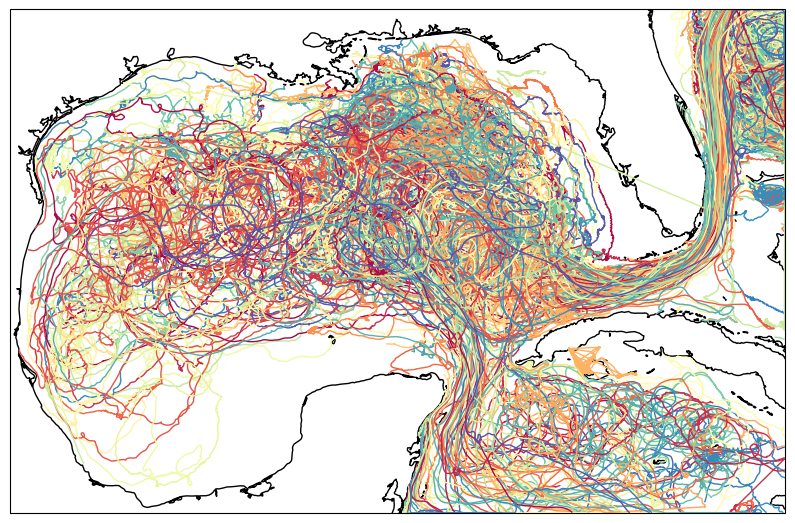

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
# plotting all the segments together
lc = LineCollection(trajs, cmap=plt.cm.Spectral, transform=ccrs.PlateCarree(), alpha=1.0)
lc.set_array(np.random.random(len(trajs))) # random color
lc.set_linewidth(1)
ax.add_collection(lc)
ax.set_xlim([-98, -78])
ax.set_ylim([18,31])
ax.coastlines()    

## 1.3 Further segmenting Lagrangian data

Now imagine that we want to analyze contiguous hourly segments of trajectories. We need to redefine the rows of the ragged array to make sure that each row is constituted of a contiguous segment of hourly data points. In other words, we want divide up, or *segment* the individual trajectories whenever the time step is larger than one hour. Once again, we apply the clouddrift function `segment` but this time on the time variable. This returns the size of new rows for which the time interval is no more than a given tolerance, here one hour. We apply this to the single trajectory we examined earlier.

In [15]:
j = 1002 # select the 1002+1 trajectory of the global dataset (ds)
row = slice(traj_index[j], traj_index[j+1]) # create a data slice for that row

dt = np.timedelta64(3600, 's') # we define the tolerance for segmenting trajectories, here one hour or 3600 s
row1 = segment(ds.time[row],tolerance=dt)

display('Number of contiguous hourly segments: '+str(len(row1)))
display('Size of each new row: ' + str(row1))

'Number of contiguous hourly segments: 25'

'Size of each new row: [ 501  306 1733   65  279   10   77   42  213   28   27   63  122   13\n   65   37   49   11    3   36    6    4  114    9    2]'

We see above that the trajectory selected (with the slice `row`) is comprised of multiple segments (`len(row1)`) or subrows, of various lengths. To visualize the result, we use another function of the *clouddrift* library which is `apply_ragged`. This function applies a given function (here `plot` of matplotlib) to each row of a ragged array argument. The general syntax for this function is `apply_ragged(function,non-optional arguments,rowsize,optional arguments ...)`. Using this function is an aletrnative to using a loop where the size of each row is passed each time.

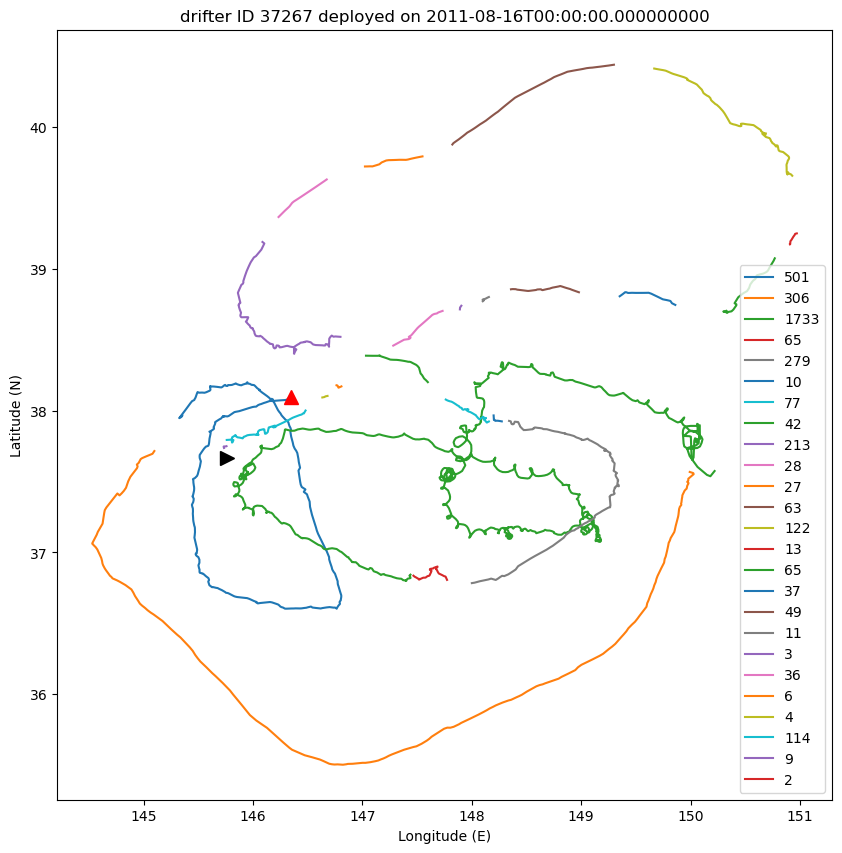

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10, 10))
r = apply_ragged(ax.plot,[ds.lon[row],ds.lat[row]],row1,marker='none',linestyle='-') # here r is an array of line objects
ax.plot(ds.lon[row][0],ds.lat[row][0],marker='^',markersize=10,color='r',label=str(ds.time[row][0].values),linestyle='none') # plot first point
ax.plot(ds.lon[row][-1],ds.lat[row][-1],marker='>',markersize=10,color='k',label=str(ds.time[row][-1].values),linestyle='none') # plot last point
ax.set_ylabel('Latitude (N)')
ax.set_xlabel('Longitude (E)')
ax.set_title(label='drifter ID '+str(ds.ID[j].values)+' deployed on '+str(ds.deploy_date[j].values))
ax.legend(r,row1,loc='best') # set the legend to display the number of data point per segment

We now apply the segmentation above but to all the individual trajectories of the ragged array. One optional argument of the `segment` function is a row size for the input argument. This input, or existing rowsize, makes the function aware of existing rows in the ragged array. This makes sense as we want to segment individual trajectories by looking for temporal gaps within a single trajectory, and not across trajectories.

In [17]:
#len(ds.time)
display(np.sum(ds.rowsize))

<xarray.DataArray 'rowsize' ()>
array(161708346)

In [18]:
# define a new rowsize variable for all contiguous segments
ds = xr.open_dataset(file,engine='zarr',decode_times=True)# reinitialize the dataset for a reason I don't understand; I think the fix on subset should fix this
rowsize0 = segment(ds.time,dt,rowsize=ds.rowsize)

In [19]:
display(np.shape(rowsize0)) # should be 88933 made out of 17324 unique trajectories originally
display(np.shape(ds.ID))

(88933,)

(17324,)

These results show that the GDP version 2.00 dataset contains 88933 contiguous hourly segments (from 17324 drifters/trajectories).

Note, however, that some of the new segments are only of length one. 

In [20]:
display(np.sum(rowsize0==1))

1130

Next, we want to illustrate the use of operations per segments, such as calculating velocity from successive positions. This requires each segment to be at least of length 2 which means that we need to remove the length-1 segments. 

To calculate velocity from positions we will need the time, latitude, and longitude. We also consider the original velocity component estimates from the dataset for comparisons, as well as the drogue status variable for data selection later on (a drifter with its drogue on is representative of ocean motions at 15-m depth, while an "undrogued" drifter is more representative of ocean currents right at the surface).

In [21]:
# not that the subset function could be used to remove segments less than a given length. 
# However, here the new rowsize does not match the original dataset but the following syntax would remove all trajectories less than 60*24 points as an example
# ds2 = subset(ds,{"rowsize": (60*24,np.inf)})

In [22]:
# Define new variables by pruning the ones contained in the original xarray dataset: time, longitude, latitude, latitude, velcoity components (ve, vn), and drogue status
min_rowsize = 2 # define the minimum length of segment we want to keep
time,rowsize = prune(ds.time,rowsize0,min_rowsize=min_rowsize) 
lon, _ = prune(ds.lon,rowsize0,min_rowsize=min_rowsize)
lat, _ = prune(ds.lat,rowsize0,min_rowsize=min_rowsize)
ve, _ = prune(ds.ve,rowsize0,min_rowsize=min_rowsize)
vn, _  = prune(ds.vn,rowsize0,min_rowsize=min_rowsize)
drogue_status, _ = prune(ds.drogue_status,rowsize0,min_rowsize=min_rowsize)

In [23]:
display(np.shape(time))
display(np.shape(rowsize))

(165753203,)

(87803,)

We have now left 87803 contiguous segments of length 2 or longer, totalling 165753203 data points.  Next, we illustrate again the use of the function `apply_ragged` to calculate velocity for each one of the contiguous segment. Here it makes sense because we want to calculate velocity from consecutive positions of the drifters only for hourly time steps. For this, we the function `velocity_from_position` from *clouddrift* that does just that: calculate Lagrangian particle velocity on a sphere (or Cartesian plane), in units of meter per unit of time provided:

In [24]:
u,v = apply_ragged(velocity_from_position,[lon,lat,time],rowsize,coord_system='spherical')

Here we can compare the velocity calculated by forward difference to the velocity provided by the dataset (variables `ds.ve` and `ds.vn`). After creating a new index for the new segments, we examine the time series of zonal velocities for the first segment as an example:

In [25]:
segment_index = np.insert(np.cumsum(rowsize), 0, 0) # create a new segment index

Text(0.5, 1.0, 'Velocity Analysis')

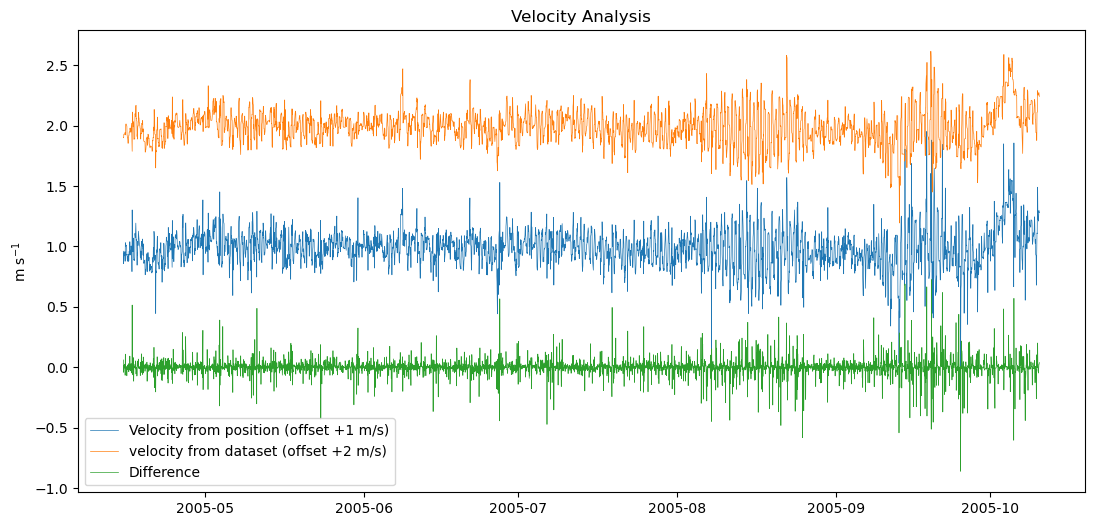

In [26]:
j = 1
row = slice(segment_index[j],segment_index[j+1])

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(13, 6))
ax.plot(time[row],u[row]*1e9+1,linewidth=0.5,label='Velocity from position (offset +1 m/s)') # multiply to get in meter per seconds
ax.plot(time[row],ve[row]+2,linewidth=0.5,label='velocity from dataset (offset +2 m/s)')
ax.plot(time[row],u[row]*1e9-ve[row],linewidth=0.5,label='Difference')
ax.legend()
ax.set_ylabel('m s$^{-1}$')
ax.set_title('Velocity Analysis')

In the plot above we can see that there are substantial differences (green) between the Lagrangian velocity calculated from positions (blue) and the velocity found in the dataset (orange). Please [Elipot et al. (2016)](http://dx.doi.org/10.1002/2016JC011716) for more details.

In this next analysis we illustrate the use of another *clouddrift* tool to compute the distance on a sphere traveled by Lagrangian particles with the function `distance` of the `sphere.haversine` submodule (to be folded in the `sphere` module).

In [27]:
speed1 = ((u*1e9)**2+(v*1e9)**2)**0.5 #speed in meter per second from apply_ragged calculation
speed0 = (ve**2+vn**2)**0.5 # speed in meter per second from dataset
dx1 = np.cumsum(speed1[row][0:-1]*3600) # cumulative distance from calculated speed
dx0 = np.cumsum(speed0[row][0:-1]*3600) # cumulative distance from original speed
dx = np.cumsum(cd.sphere.haversine.distance(lat[row][0:-1],lon[row][0:-1],lat[row][1:],lon[row][1:])) # cumulative distance from original positions
display(len(dx1),len(dx),len(time[row]))

4288

4288

4289

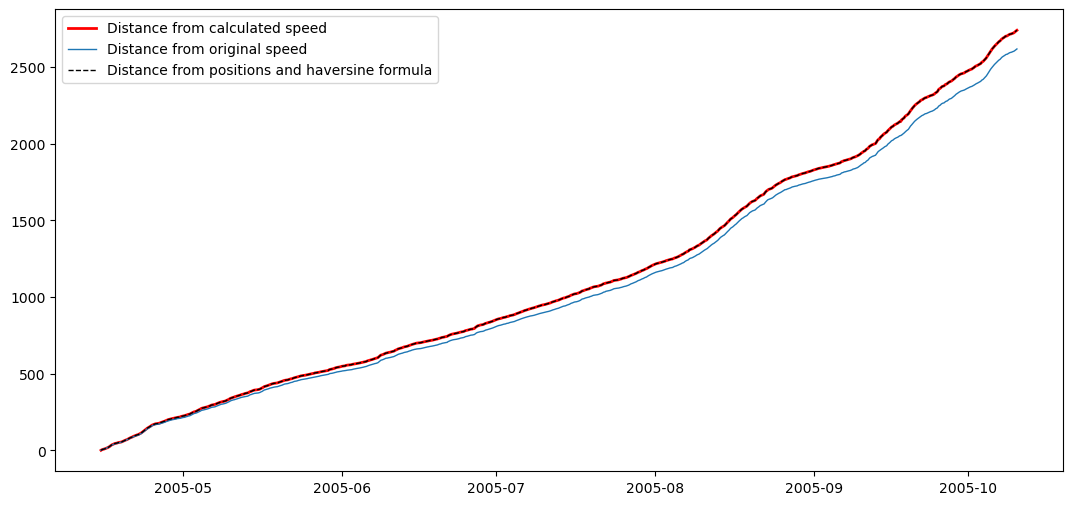

In [28]:
# plot the results
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(13, 6))
ax.plot(time[row][0:-1],dx1*1e-3,linewidth=2,label='Distance from calculated speed ',color='r') 
ax.plot(time[row][0:-1],dx0*1e-3,linewidth=1,label='Distance from original speed')
ax.plot(time[row][0:-1],dx*1e-3,linewidth=1,label='Distance from positions and haversine formula',linestyle='--',color='k')
ax.legend();
# this reveals something about the calculation of velocity from positions

The above plot shows the consistency between the `velocity_from_position` function and the `haversine.distance` function.

# 2. Latitude-Frequency velocity spectra

## 2.1 Spectra estimates
We now want to use the velocity data to estimate the average spectrum of oceanic velocity, which can be interpreted as decomposing kinetic energy as a function of frequency. For this, we need to calculate a spectral estimate for a number of fixed-length segments, or chunks, of velocity time series. The clouddrift library provide a tool, `chunk` to split up row of various lengths in equal-size chunks.

A diagram explaining the chunking

In the following we seek to estimate spectra for 60-day long chunks of data segments. To do this we use the `chunk` in combination with apply_ragged in order to chunk each trajectory individually but assemble the total result:

In [29]:
N = 60*24 # make 60-day chunks or 60*24 point chunks
ve60 = apply_ragged(chunk,ve,rowsize,N,overlap=0,align='middle') # east-west velocity chunking
vn60 = apply_ragged(chunk,vn,rowsize,N,overlap=0,align='middle') # north-south velocity chunking
lat60 = apply_ragged(chunk,lat,rowsize,N,overlap=0,align='middle') # latitude chunking
ds60 = apply_ragged(chunk,drogue_status,rowsize,N,overlap=0,align='middle') # drogue status variable chunking
display(np.shape(lat60))

(97053, 1440)

We now see that we have been able to generate 97,053 chunks of 60-day length from the drifter dataset! Now we can calculate the spectral estimates with a simple periodogram as an example. Estimating spectral estimate is not trivial in itself but we keep it simple here. The most important is the choice of normalization which we think we have handled properly here. One of us (Shane Elipot) put together a repo with a notebook example with some references [here](https://github.com/selipot/congenial-spectrum) if you'd like to read further.

In [30]:
# form the complex-valued velocity variable
z60 = (ve60+1j*vn60) # in m/s
# form a normalized boxcar window
wr = np.ones(z60.shape[1]); 
boxcar_fac = np.square(wr).sum()
wr = wr/np.sqrt(boxcar_fac)
# calculate the estimates of spectral densities
# zfft = np.fft.fft((z-np.mean(z,axis=-1,keepdims=True))*wr,axis=-1) # no mean
zfft = np.fft.fft(z60*wr,axis=-1) # with mean
dth = 1/24 # we want to get the frequency unit in cpd
szz = (np.abs(zfft)**2)*dth

Next, we plot one spectral estimate to verify that we did a sensible job:

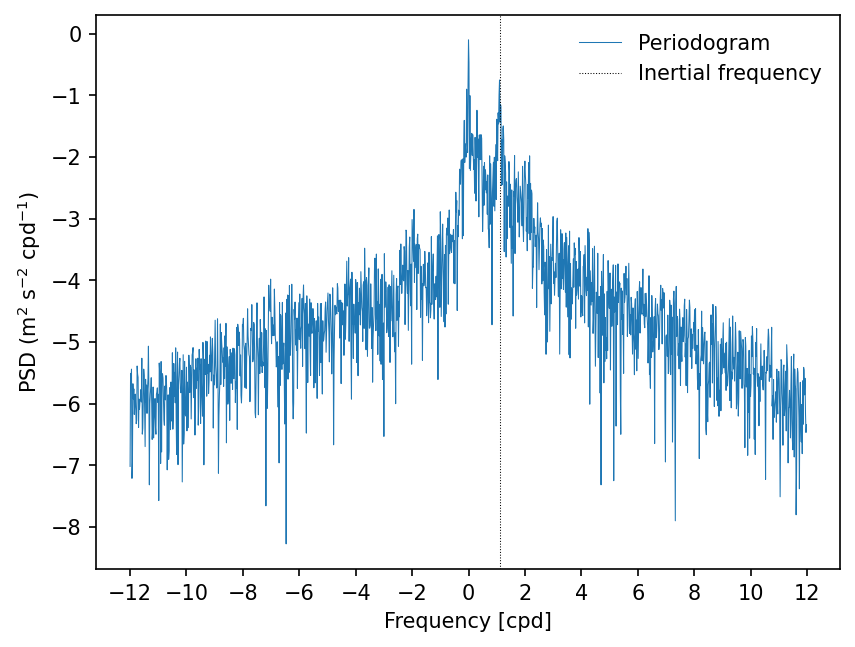

In [31]:
# plot one example: 10 from last
n = -10
# calculate inertial frequency in cycle per day [cpd] from the mean latitude of trajectory
omega = 7.2921159e-5  # Earth's rotation rate [rad/s]
seconds_per_day = 60*60*24  # [s]
fi = -2*omega*(seconds_per_day/(2*np.pi))*np.sin(np.radians(lat60[n,:]).mean())

# define the frequency axis for time series of length N with sampling interval dth in days
f = np.fft.fftfreq(N,dth)

fig = plt.figure(dpi=150)
ax = fig.add_subplot(1,1,1)

h1, = ax.plot(np.fft.fftshift(f), np.fft.fftshift(np.log10(szz[n,:])), scaley=True, label='Periodogram', linewidth=0.5)
h2 = ax.axvline(x=fi,color='k',linestyle=':', label='Inertial frequency', linewidth=0.5)
ax.legend(frameon=False)
ax.set_ylabel('PSD (m$^2$ s$^{-2}$ cpd$^{-1}$)')
ax.set_xticks(np.arange(-12,13,2))
ax.set_xlabel('Frequency [cpd]');

## 2.2 Spectra selection and averaging

Next, we estimate an average rotary spectrum in 1 degree latitude bands. We want to be able to distinguish complete drogued and undrogued segments. So we consider the mean latitude (`mlat60`) and the sum of drogue status (`sds60`)

In [32]:
mlat60 = np.mean(lat60,axis=-1) # define mean latitude of each chunk
sds60 = np.sum(ds60,axis=-1) # calculate the number of drogued estimates per chunk

In [33]:
# how many undrogued, how many drogued, how many mixed?
qd = sds60 == N # if N it means all estimates per chunks are drogued
qu = sds60 == 0 # if 0 it means that all estimates per chunks are undrogued
#display(np.sum(sds60==0),np.sum(sds60==1440),len(sds60)-np.sum(sds60==0)-np.sum(sds60==1440))
print('Number of drogued chunks: '+str(np.sum(qd)))
print('Number of undrogued chunks: '+str(np.sum(qu)))
print('Number of "mixed" chunks: '+str(len(sds60)-np.sum(qd)-np.sum(qu)))


Number of drogued chunks: 31275
Number of undrogued chunks: 58071
Number of "mixed" chunks: 7707


First, we calculate a globally averaged spectra as in [Yu et al 2019](https://doi.org/10.1029/2019GL083074) and [Arbic et al. 2022](https://doi.org/10.1029/2022JC018551):

In [34]:
# This piece of code compute the globally averaged spectra
# create the indices for averaging frequencies
ind1 = list(range(721)) # list of positive frequencies from zero to 12 cpd
ind2 = list(range(1))+list(range(1439,719,-1)) # reorganizing of negative frequencies from 0 to 12 cpd
qp = mlat60>=0 # find chunks in the NH, including equator
qn = mlat60<0 # find chunks in the SH
# gather NH cyclonic and SH cyclonic, drogued 
Stmp = szz[qp & qd,:]
Sc1 = Stmp[:,ind1] # how to do these two operations in one go????? pisses me off
Stmp = szz[qn & qd,:]
Sc2 = Stmp[:,ind2] # how to do these two operations in one go????? pisses me off
Sc_d = np.mean(np.concatenate((Sc1,Sc2),axis=0),axis=0)
# gather NH anticyclonic and SH anticyclonic, drogued
Stmp = szz[qp & qd,:]
Sac1 = Stmp[:,ind2] # how to do these two operations in one go????? pisses me off
Stmp = szz[qn & qd,:]
Sac2 = Stmp[:,ind1] # how to do these two operations in one go????? pisses me off
Sac_d = np.mean(np.concatenate((Sac1,Sac2),axis=0),axis=0)

# gather NH cyclonic and SH cyclonic, undrogued 
Stmp = szz[qp & qu,:]
Sc1 = Stmp[:,ind1] # how to do these two operations in one go????? pisses me off
Stmp = szz[qn & qu,:]
Sc2 = Stmp[:,ind2] # how to do these two operations in one go????? pisses me off
Sc_u = np.mean(np.concatenate((Sc1,Sc2),axis=0),axis=0)
# gather NH anticyclonic and SH anticyclonic, undrogued
Stmp = szz[qp & qu,:]
Sac1 = Stmp[:,ind2] # how to do these two operations in one go????? pisses me off
Stmp = szz[qn & qu,:]
Sac2 = Stmp[:,ind1] # how to do these two operations in one go????? pisses me off
Sac_u = np.mean(np.concatenate((Sac1,Sac2),axis=0),axis=0)

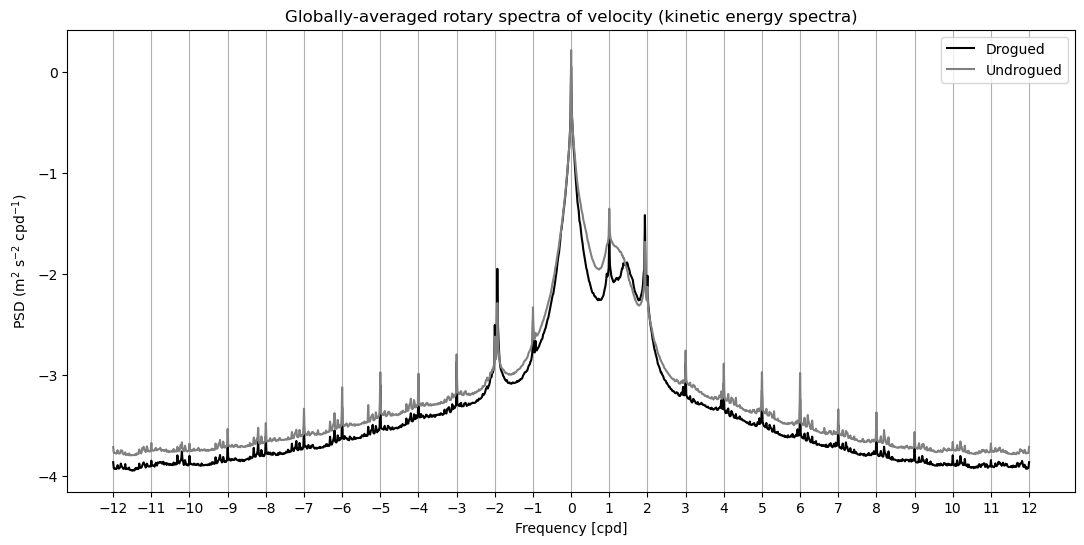

In [35]:
fa = np.append(np.arange(0,12,1/60),12)# create frequency scale
# do the plotting
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(13, 6))
ax.plot(-fa,np.log10(Sc_d),scaley=True,color='k',label='Drogued')
ax.plot(fa,np.log10(Sac_d),scaley=True,color='k')
ax.plot(-fa,np.log10(Sc_u),scaley=True,color=(0.5,0.5,0.5),label='Undrogued')
ax.plot(fa,np.log10(Sac_u),scaley=True,color=(0.5,0.5,0.5))
ax.legend()
ax.set_ylabel('PSD (m$^2$ s$^{-2}$ cpd$^{-1}$)')
ax.set_xlabel('Frequency [cpd]');
ax.set_xticks(np.arange(-12,13));
ax.xaxis.grid(True)
ax.set_title('Globally-averaged rotary spectra of velocity (kinetic energy spectra)');

We now repeat the calculation but in latitude bands of one degree to obtain a latitude-frequency spectra. The mean latitudes of the chunks span from about 78S to almost 90N:

In [36]:
display(np.min(mlat60),np.max(mlat60)) # so from -78 to 89
latbins = np.arange(-78,91) # define latitude bands
display(len(latbins))

-77.53924

89.406395

169

In [37]:
ind = list(range(720,1440))+list(range(721)) # rearrange the order of the frequencies, this is similar to numpy.fft.fftshift but here we repeat the Nyquist frequency

In [38]:
# initialize the spectra variables
Sd = np.empty((len(latbins)-1,len(ind)));Sd[:] = np.nan
Su = np.empty((len(latbins)-1,len(ind)));Su[:] = np.nan
#display(np.shape(S))
Nd = np.zeros(len(latbins)-1)
Nu = np.zeros(len(latbins)-1)
N = np.zeros(len(latbins)-1)
#display(np.shape(N))

# do a loop to calculate average at each latitude
Stmp = szz[:,ind]
for i in range(0,len(latbins)-1):
    #print(latbins[i],latbins[i+1]) # something strange is happening with the loop or the display
    q = (mlat60>=latbins[i]) & (mlat60<latbins[i+1])
    N[i] = np.sum(q)
    Nd[i] = np.sum(q & qd)
    Nu[i] = np.sum(q & qu)
    Sd[i,:] = np.mean(Stmp[q & qd,:],axis=0)
    Su[i,:] = np.mean(Stmp[q & qu,:],axis=0)

/Users/selipot/opt/mambaforge/envs/cdex/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/selipot/opt/mambaforge/envs/cdex/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/Users/selipot/opt/mambaforge/envs/cdex/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


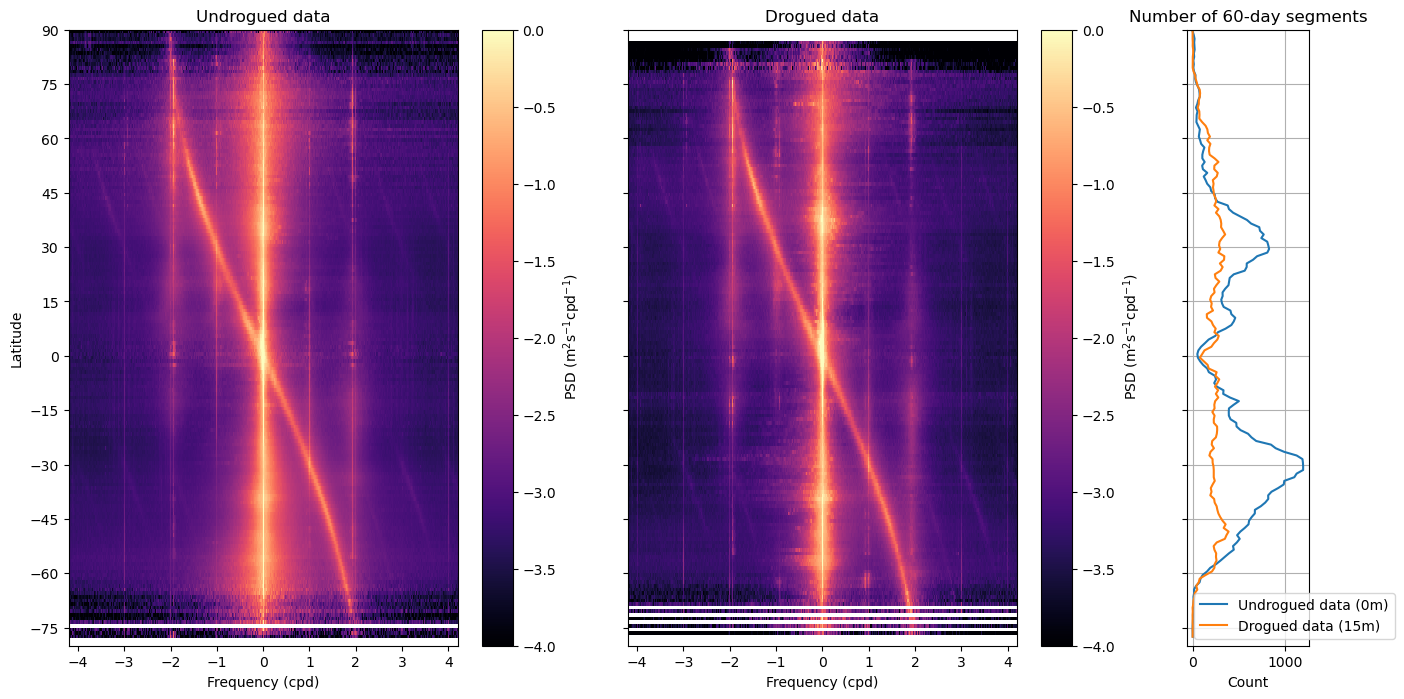

In [39]:
# plot result for undrogued drifter only
# define a mesh for frequencies
fe = np.append(np.fft.fftshift(f)-1/120,[12-1/120,12+1/60-1/120])

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(16, 8),sharey=True,gridspec_kw={'width_ratios': [4, 4, 1]})
im = ax[0].pcolormesh(fe,latbins,np.log10(Su),vmin=-4,vmax=0,cmap='magma')
ax[0].set_xlim(-4.2,4.2)
ax[0].set_xticks(np.arange(-4,5,1))
ax[0].set_ylabel('Latitude')
ax[0].set_yticks(np.arange(-90,90+15,15))
ax[0].set_ylim(-80,90)
ax[0].set_title('Undrogued data')
ax[0].set_xlabel('Frequency (cpd)')
plt.colorbar(im,ax=ax[0],location='right',label=' PSD (m$^2$s$^{-1}$cpd$^{-1}$)')

ax[1].pcolormesh(fe,latbins,np.log10(Sd),vmin=-4,vmax=0,cmap='magma')
ax[1].set_xlim(-4.2,4.2)
ax[1].set_xticks(np.arange(-4,5,1))
ax[1].set_yticks(np.arange(-90,90+15,15))
ax[1].set_ylim(-80,90)
ax[1].set_title('Drogued data')
ax[1].set_xlabel('Frequency (cpd)')
plt.colorbar(im,ax=ax[1],location='right',use_gridspec='True',label=' PSD (m$^2$s$^{-1}$cpd$^{-1}$)')

ax[2].plot(Nu,0.5*(latbins[0:-1]+latbins[1:]),label='Undrogued data (0m)')
ax[2].plot(Nd,0.5*(latbins[0:-1]+latbins[1:]),label='Drogued data (15m)')
ax[2].set_yticks(np.arange(-90,90+15,15))
ax[2].set_ylim(-80,90)
ax[2].set_xlabel('Count')
ax[2].grid()
ax[2].legend();
ax[2].set_title('Number of 60-day segments');


This concludes the example based on the GDP!

# 3. Scaling it up: synthetic Lagrangian trajectories released in HYCOM numerical model of the global ocean

This a work in progress!